In [1]:
import pybedtools
import pandas as pd
from scipy.stats import fisher_exact
from numpy import log10, mean, max, quantile, corrcoef, median
from scipy import stats
import matplotlib.pyplot as plt
from re import sub
%matplotlib inline

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'bd_analysis_results'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Analysis of baited digests classes with respect to underlying baits

We used the BD-score to divide baited digests into BDC0, BDC1 and BDC2 classes based on which configurations predominate in interactions that go from a baited digest towards 5' or 3' direction. In this notebook, we examine the baited digests of the various classes with respect to the baits that were used for the underlying capture Hi-C experiments.

## Input files

We use the bait coordinates from the publication by [Mifsud et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25938943/) and the coordinates of the digests selected for enrichment from the publication by [Javierre et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27863249/). In our documentation on Read The Docs we describe in detail how we prepared these files for this analysis (file format conversion and LiftOver from `hg19` to `hg38`). In addition, we use three BED files with digests of classes BDC0, BDC1 and BDC2, which we previously created in the `baited_digest_analysis_1` notebook. Finally, we use the `hg38` reference sequence to analyze the GC content of baits. In our documentation on Read The Docs we describe how to download such data from iGenome's website.

In [2]:
# BED files for BDC0, BDC1 and BDC2 baited digests
AUTHOR = 'JAV' # MIF or JAV
CELL_TYPE_SHORT = 'MAC_M0' # GM12878, MK, ERY, NEU, MON, MAC_M0, ...
PROTOCOL = 'CHC' # HC or CHC
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
BDC0_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + OUT_PREFIX  + '_bdc0.bed')
BDC1_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + OUT_PREFIX  + '_bdc1.bed')
BDC2_DIGEST_FILE = pybedtools.BedTool(NOTEBOOK_RESULTS_DIR + '/bdc_lists/' + OUT_PREFIX  + '_bdc2.bed')

# BED file with all baits
MIFSUD_BAIT_FILE = pybedtools.BedTool('../../additional_files/mifsud_2015/mifsud_baits_hg38.bed')
#MIFSUD_BAIT_FILE = pybedtools.BedTool('../../additional_files/mifsud_2015/mifsud_baits_hg19.bed')

# BED file with all baited digests
BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/javierre_baited_digests_hg38.bed')
#BAITED_DIGEST_FILE = pybedtools.BedTool('../../additional_files/javierre_2016/javierre_baited_digests_hg19.bed')

# Genome sequence file for GC content analysis
# A corresponding index file 'genome.fa.fai' must be in the same directory
HG38_GENOME_FILE = '../../additional_files/reference_sequence/hg38_genome.fa'

## Preparation of a dictionary with coordinates of digests and associated baits

The central data structure in this analysis is a dictionary from which one can retrieve the coordinates of baits associated with a given digest using the coordinates of the digest. In this section we create this data structure.

To map baited digests to the different classes, we create three sets of digest coordinates.

In [3]:
BDC0_set = set()
for d in BDC0_DIGEST_FILE:
    BDC0_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
    
BDC1_set = set()
for d in BDC1_DIGEST_FILE:
    BDC1_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
    
BDC2_set = set()
for d in BDC2_DIGEST_FILE:
    BDC2_set.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))

We use BedTools' `intersect` command to assign baits to digests. The option `F=1.00` causes an overlap to be reported only if a bait is completely contained in the digest.

In [4]:
DIGESTS_WITH_BAIT_COORDS = BAITED_DIGEST_FILE.intersect(MIFSUD_BAIT_FILE, wa=True, wb=True, F=1.00)
DIGESTS_WITH_BAIT_COORDS.head()

chr1	896515	912788	chr1	912476	912596
 chr1	912789	915238	chr1	912789	912909
 chr1	912789	915238	chr1	915001	915121
 chr1	915239	938701	chr1	915239	915359
 chr1	915239	938701	chr1	938577	938697
 chr1	954044	968260	chr1	954103	954223
 chr1	954044	968260	chr1	968140	968260
 chr1	968261	992014	chr1	968261	968381
 chr1	968261	992014	chr1	991894	992014
 chr1	992015	1001574	chr1	1001421	1001541
 

Out of a total of 37,602 baits, 30 baits could not be assigned to any digest.

In [5]:
print('Total number of baits: ' + str(len(MIFSUD_BAIT_FILE)))
print('Assigned baits: ' + str(len(DIGESTS_WITH_BAIT_COORDS)))
print('Unassigned baits: ' + str(len(MIFSUD_BAIT_FILE) - len(DIGESTS_WITH_BAIT_COORDS)))

Total number of baits: 37602
Assigned baits: 37572
Unassigned baits: 30


Out of a total of 22,056 baited digests one digest was not assiged a bait.

In [6]:
# Find digests to which no baits was assigned
dset_1 = set()
for d in BAITED_DIGEST_FILE:
    dset_1.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
print('Total number of baited digests: ' + str(len(dset_1)))
dset_2 = set()
for d in DIGESTS_WITH_BAIT_COORDS:
    dset_2.add(d.chrom + '\t' + str(d.start) + '\t' + str(d.end))
print('Number of digests with at least one bait: ' + str(len(dset_2)))
dset_3 = dset_1 - dset_2
for d in dset_3:
    print(d)

Total number of baited digests: 22056
Number of digests with at least one bait: 22055
chr22_KI270879v1_alt	275558	284927


These cases are due to the LiftOver from `hg19` to `hg38`. Comment in the appropriate lines for `hg19` at the top of this notebook to verify this.

Next, we store the overlap information from the file we just created with BedTools in a dictionary. The keys are the coordinates of the digests, and for each digest, the coordinates of the baits associated with the 5' or 3' end of the digest are stored separately, where we assign given baits to the digest end that is closer. In addition, the baited digest class (`0`, `1`, `2`) is stored for each digest. We implemented the creation of such a dictionary in the following function.

In [7]:
def get_digest_with_baits_dict(DIGESTS_WITH_BAIT_COORDS):
    
    # Dictionary to be created
    DIGESTS_WITH_BAITS_DICT = dict()
    
    # Iterate through the file created with BedTools intersect
    for d in DIGESTS_WITH_BAIT_COORDS:
        
        # Split line with digest and bait coordinates
        arr = str(d).split('\t')
        d_chr = arr[0]
        d_sta = int(arr[1])
        d_end = int(arr[2])
        b_chr = arr[3]
        b_sta = int(arr[4])
        b_end = int(arr[5])

        # Calculate the center positions of the digest and the overlapping bait
        d_len = d_end - d_sta + 1
        d_center_pos = d_sta + int(d_len/2) + 1
        b_len = b_end - b_sta + 1  
        b_center_pos = b_sta + int(b_len/2) + 1
        
        # Get keys for digest and overlapping bait
        d_key = d_chr + '\t' + str(d_sta) + '\t' + str(d_end)
        b_key = b_chr + '\t' + str(b_sta) + '\t' + str(b_end)

        # Create dictionary for this digest if none exists yet
        if d_key not in DIGESTS_WITH_BAITS_DICT:
            DIGESTS_WITH_BAITS_DICT[d_key] = dict()
            DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'] = []
            DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'] = []
            
        # Assign the overlapping bait to the 5' or 3' end of the digest
        if b_center_pos < d_center_pos:
            DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'].append(b_key)
        else:
            DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'].append(b_key)
                
        # Assign the digest to one of the BD classes
        if d_key in BDC1_set:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 1
        elif d_key in BDC2_set:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 2
        elif d_key in BDC0_set:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 0
        else:
            DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] = 'X' # No interactions at this digest
                        
    return DIGESTS_WITH_BAITS_DICT

We now use the function to create the dictionary.

In [8]:
DIGESTS_WITH_BAITS_DICT = get_digest_with_baits_dict(DIGESTS_WITH_BAIT_COORDS)

Here are the first five items to illustrate the data structure:

In [9]:
print(list(DIGESTS_WITH_BAITS_DICT.items())[:5])

[('chr1\t896515\t912788', {'L_COORDS': [], 'R_COORDS': ['chr1\t912476\t912596'], 'BDC': 0}), ('chr1\t912789\t915238', {'L_COORDS': ['chr1\t912789\t912909'], 'R_COORDS': ['chr1\t915001\t915121'], 'BDC': 0}), ('chr1\t915239\t938701', {'L_COORDS': ['chr1\t915239\t915359'], 'R_COORDS': ['chr1\t938577\t938697'], 'BDC': 1}), ('chr1\t954044\t968260', {'L_COORDS': ['chr1\t954103\t954223'], 'R_COORDS': ['chr1\t968140\t968260'], 'BDC': 0}), ('chr1\t968261\t992014', {'L_COORDS': ['chr1\t968261\t968381'], 'R_COORDS': ['chr1\t991894\t992014'], 'BDC': 0})]


Information about a particular digest can be retrieved using the digest coordinates (key) as follows:

In [10]:
print('5\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['L_COORDS']))
print('3\' bait coordinates: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['R_COORDS']))
print('BD class: ' + str(DIGESTS_WITH_BAITS_DICT['chr1\t896515\t912788']['BDC']))

5' bait coordinates: []
3' bait coordinates: ['chr1\t912476\t912596']
BD class: 0


## Counting digests according to different aspects

We now use the data structure to count digests according to different aspects.

### Digests with none, one, two or more baits

In [11]:
cnt_dict = {'0': 0, '1': 0, '2': 0, '2<':0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bait_num = len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'] + DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])
    if 2 < bait_num:
        cnt_dict['2<'] += 1
    else:
        cnt_dict[str(bait_num)] += 1
        
# Report counts
for key in cnt_dict.keys():
    digest_num = cnt_dict[key]
    percentage = 100*cnt_dict[key]/sum(cnt_dict.values())
    print(key + ' baits: ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(cnt_dict.values())))

0 baits: 0 (0.00%)
1 baits: 6,538 (29.64%)
2 baits: 15,517 (70.36%)
2< baits: 0 (0.00%)
Total number of baited digests: 22,055


### BCD0, BDC1, BDC2 and BDCX digests

In [12]:
cnt_dict = {'0': 0, '1': 0, '2': 0, 'X': 0}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    cnt_dict[str(DIGESTS_WITH_BAITS_DICT[d_key]['BDC'])] += 1

for key in cnt_dict.keys():
    digest_num = cnt_dict[key]
    percentage = 100*cnt_dict[key]/sum(cnt_dict.values())
    print('BDC' + key + ': ' + '{:,}'.format(digest_num) + ' (' + '{:.2f}'.format(percentage) + '%)')
print('Total number of baited digests: ' + '{:,}'.format(sum(cnt_dict.values())))
x = sum(cnt_dict.values()) - cnt_dict['X']
print('Number of baited digests with interactions: ' + '{:,}'.format(x))

BDC0: 8,055 (36.52%)
BDC1: 6,170 (27.98%)
BDC2: 7,662 (34.74%)
BDCX: 168 (0.76%)
Total number of baited digests: 22,055
Number of baited digests with interactions: 21,887


Digests of class BDCX are not associated with any interactions. Therefore, they do not appear in the `BaitedDigestSet` and are not considered in the classification of the baited digests into the classes BDC0, BDC1 and BDC2. They make up only a small proportion of all baited digests and are listed here for the sake of completeness. We exclude BDCX digests from all subsequent analyses.

In [13]:
tmp_dict = dict()
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    if DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] != 'X':
        tmp_dict[d_key] = DIGESTS_WITH_BAITS_DICT[d_key]
DIGESTS_WITH_BAITS_DICT = tmp_dict

### BDC0, BDC1 and BDC2 digests with baits on only one or both sides

Count digests.

In [14]:
cnt_dict = {
    'BDC0': {'ONE_SIDE': 0, 'BOTH_SIDES': 0},
    'BDC1': {'ONE_SIDE': 0, 'BOTH_SIDES': 0},    
    'BDC2': {'ONE_SIDE': 0, 'BOTH_SIDES': 0}
}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    bdc = DIGESTS_WITH_BAITS_DICT[d_key]['BDC']
    if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])==0 or len(DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])==0:
        cnt_dict['BDC' + str(bdc)]['ONE_SIDE'] += 1
    else:
        cnt_dict['BDC' + str(bdc)]['BOTH_SIDES'] += 1

Report counts and percentages within BD classes.

In [15]:
print('Counts:')
df = pd.DataFrame(data=cnt_dict)
print(df)
print('\nPercentages within BD classes:')
print(df.div(df.sum(axis=0), axis=1).round(4)*100)

Counts:
            BDC0  BDC1  BDC2
ONE_SIDE     588  2859  3021
BOTH_SIDES  7467  3311  4641

Percentages within BD classes:
            BDC0   BDC1   BDC2
ONE_SIDE     7.3  46.34  39.43
BOTH_SIDES  92.7  53.66  60.57


Report percentages within digests with baits on only one or both sides.

In [16]:
df2 = df[['BDC0','BDC1','BDC2']]
print('\nPercentages within one- and two-sided baited digests:')
print(df2.div(df2.sum(axis=1), axis=0).round(4)*100)


Percentages within one- and two-sided baited digests:
             BDC0   BDC1   BDC2
ONE_SIDE     9.09  44.20  46.71
BOTH_SIDES  48.43  21.47  30.10


Create contingency table with combined column for BDC1 and BDC2.

In [17]:
df_cont = df.drop(columns=['BDC1', 'BDC2'])
df_cont['BDC12'] = df['BDC1'] + df['BDC2']
df_cont.loc['Total'] = df_cont.sum(numeric_only=True,axis=0)
df_cont.loc[:,'Total'] = df_cont.sum(numeric_only=True,axis=1)
df_cont

,BDC0,BDC12,Total
ONE_SIDE,588,5880,6468
BOTH_SIDES,7467,7952,15419
Total,8055,13832,21887


Perform a Fisher's exact test for this contingency table.

In [18]:
# Fisher's exact test
contingency_table = [
    [df_cont['BDC0']['ONE_SIDE'], df_cont['BDC12']['ONE_SIDE']],
    [df_cont['BDC0']['BOTH_SIDES'], df_cont['BDC12']['BOTH_SIDES']]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 0.10649524574795768
P-value: 0.0


### Digests with baits on only one side separated by 5' and 3'

Count digests.

In [19]:
cnt_dict = {
    'BDC0': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0},
    'BDC1': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0},    
    'BDC2': {'5_BAIT_NUM': 0, '3_BAIT_NUM': 0}
}
for d_key in DIGESTS_WITH_BAITS_DICT.keys():
    
    # Get BD class
    bdc = DIGESTS_WITH_BAITS_DICT[d_key]['BDC']
    
    # Restict analysis to digest with only one bait
    if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])==0 or len(DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])==0:
        
        # Count digests with baits on the 5' or 3' end
        if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])==0:     
            cnt_dict['BDC' + str(bdc)]['3_BAIT_NUM'] += 1
        else:
            cnt_dict['BDC' + str(bdc)]['5_BAIT_NUM'] += 1

Report counts.

In [20]:
df = pd.DataFrame(data=cnt_dict)
df.index = ['5\' baits', '3\' baits']
df.loc['Total'] = df.sum(numeric_only=True,axis=0)
df.loc[:,'Total'] = df.sum(numeric_only=True,axis=1)
df.T

,5' baits,3' baits,Total
BDC0,316,272,588
BDC1,2859,0,2859
BDC2,4,3017,3021
Total,3179,3289,6468


Perform Fisher's exact test for BDC1 and BDC2.

In [21]:
contingency_table = [
    [cnt_dict['BDC1']['5_BAIT_NUM'], cnt_dict['BDC1']['3_BAIT_NUM']],
    [cnt_dict['BDC2']['5_BAIT_NUM'], cnt_dict['BDC2']['3_BAIT_NUM']]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: inf
P-value: 0.0


## Further analysis of digests with baits on both sides

For the following analyzes, we only consider digests that have baits on both sides. For BDC1, we find find many examples where the `5'` end bait is right next to the restriction site (as it should be), and the `3'` end bait is shifted towards the center of the digest (as is it accepted if a bait cannot be placed better).
```
5'|--------------3'
   -          -
```
BDC1 example: ``chr2:208,144,486-208,147,056``.

For BDC2 it is exactly the opposite.
```
5'--------------|3'
    -          -
```
BDC2 example: ``chr2:102,179,857-102,182,542``.

### Distances between baits and restriction sites

The following function determines the distances from baits to digest ends for given baited digest classes.

```
5'-------------------3'
     -          -
  <->             <->
  d_l             d_r
               
```
In order to ensure that there is a pair of distances for each digest, it is required that there is exactly one bait for each digest end. If the difference in the distances of a pair is small (`max_diff<20`), this means that both baits have a similar distance from the corresponding digest end. Such digests are added to a dictionary which is returned together with the two lists of distances and will be be used for subsequent analyzes.

In [22]:
def get_distances_from_baits_to_restriction_site(digest_with_baits_dict, bd_classes=[0,1,2], max_dist=20):
    l_dist_list = []
    r_dist_list = []
    digest_with_baits_well_placed_dict = dict()
    for d_key in digest_with_baits_dict.keys():
        
        # Filter for digests with specified baited digest classes
        if DIGESTS_WITH_BAITS_DICT[d_key]['BDC'] not in bd_classes:
            continue
            
        # Make sure that the digest has one 5' and one 3' bait
        if len(DIGESTS_WITH_BAITS_DICT[d_key]['L_COORDS'])!=1 or len(DIGESTS_WITH_BAITS_DICT[d_key]['R_COORDS'])!=1:
            continue
            
        # Determine distance for 5' bait
        d_sta = int(d_key.split('\t')[1])
        b5_sta = int(digest_with_baits_dict[d_key]['L_COORDS'][0].split('\t')[1])
        l_dist = b5_sta - d_sta
        
        # Determine distance for 3' bait
        d_end = int(d_key.split('\t')[2])
        b3_end = int(digest_with_baits_dict[d_key]['R_COORDS'][0].split('\t')[2])
        r_dist = d_end - b3_end
        
        # Add digests to dictionary which will be returned along with the lists of distances
        if l_dist <= max_dist and r_dist <= max_dist:
            digest_with_baits_well_placed_dict[d_key] = DIGESTS_WITH_BAITS_DICT[d_key]
        else:
            l_dist_list.append(l_dist)
            r_dist_list.append(r_dist)
            
            
    num_well_placed = len(digest_with_baits_well_placed_dict)  
    num_not_well_placed = len(l_dist_list)
    prop_well_placed = 100*num_well_placed/(num_well_placed + num_not_well_placed)
    prop_not_well_placed = 100*num_not_well_placed/(num_well_placed + num_not_well_placed)
            
    print('BDC' + str(bd_classes))
    print('\tNumber 5\' bait distances: ' + '{:,}'.format(len(l_dist_list)))
    print('\tNumber 3\' bait distances: ' + '{:,}'.format(len(r_dist_list)))  
    print('\tNumber of digests with well placed baits: ' + '{:,}'.format(num_well_placed) + ' (' + '{:.2f}'.format(prop_well_placed) + '% vs. ' + '{:.2f}'.format(prop_not_well_placed) + ')')

    return l_dist_list, r_dist_list, digest_with_baits_well_placed_dict

We apply the function to the different baited digest classes. For each function call, we get two lists with distances and a dictionary that only contains digests for which the distances of the two baits do not differ much (`max_diff=20`). These dictionaries will be used for the subsequent analyzes of the GC and repeat content of baits.

In [23]:
MAX_DIST = 20
bdc0_l_dist_list, bdc0_r_dist_list, bdc0_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[0], max_dist=MAX_DIST)

bdc1_l_dist_list, bdc1_r_dist_list, bdc1_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[1], max_dist=MAX_DIST)

bdc2_l_dist_list, bdc2_r_dist_list, bdc2_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[2], max_dist=MAX_DIST)

bdc12_l_dist_list, bdc12_r_dist_list, bdc12_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[1,2], max_dist=MAX_DIST)

bdcALL_l_dist_list, bdcALL_r_dist_list, bdcALL_well_placed_dict = get_distances_from_baits_to_restriction_site(
    DIGESTS_WITH_BAITS_DICT,
    bd_classes=[0,1,2], max_dist=MAX_DIST)

BDC[0]
	Number 5' bait distances: 3,851
	Number 3' bait distances: 3,851
	Number of digests with well placed baits: 3,616 (48.43% vs. 51.57)
BDC[1]
	Number 5' bait distances: 2,600
	Number 3' bait distances: 2,600
	Number of digests with well placed baits: 711 (21.47% vs. 78.53)
BDC[2]
	Number 5' bait distances: 3,212
	Number 3' bait distances: 3,212
	Number of digests with well placed baits: 1,429 (30.79% vs. 69.21)
BDC[1, 2]
	Number 5' bait distances: 5,812
	Number 3' bait distances: 5,812
	Number of digests with well placed baits: 2,140 (26.91% vs. 73.09)
BDC[0, 1, 2]
	Number 5' bait distances: 9,663
	Number 3' bait distances: 9,663
	Number of digests with well placed baits: 5,756 (37.33% vs. 62.67)


In [24]:
# Contingency table
BDC12_NOT_WELL_PLACED = len(bdc12_l_dist_list)
BDC12_WELL_PLACED = len(bdc12_well_placed_dict)
BDC12_TOTAL = BDC12_NOT_WELL_PLACED + BDC12_WELL_PLACED
BDC0_NOT_WELL_PLACED = len(bdc0_l_dist_list)
BDC0_WELL_PLACED = len(bdc0_well_placed_dict)
BDC0_TOTAL = BDC0_NOT_WELL_PLACED + BDC0_WELL_PLACED

d = {'Not well placed': ['{:,}'.format(BDC12_NOT_WELL_PLACED),
                  '{:,}'.format(BDC0_NOT_WELL_PLACED),
                  '{:,}'.format(BDC12_NOT_WELL_PLACED + BDC0_NOT_WELL_PLACED)],
     'Well placed': ['{:,}'.format(BDC12_WELL_PLACED),
                    '{:,}'.format(BDC0_WELL_PLACED),
                    '{:,}'.format(BDC12_WELL_PLACED + BDC0_WELL_PLACED)],
     'Total': ['{:,}'.format(BDC12_NOT_WELL_PLACED + BDC12_WELL_PLACED),
               '{:,}'.format(BDC0_NOT_WELL_PLACED + BDC0_WELL_PLACED),
               '{:,}'.format(BDC12_TOTAL + BDC0_TOTAL)]}
df = pd.DataFrame(data=d)
df.index = ['BDC12', 'BDC0', 'Total']
df

,Not well placed,Well placed,Total
BDC12,"5,812","2,140","7,952"
BDC0,"3,851","3,616","7,467"
Total,"9,663","5,756","15,419"


In [25]:
# Fisher's exact test
contingency_table = [
    [BDC12_NOT_WELL_PLACED, BDC12_WELL_PLACED],
    [BDC0_NOT_WELL_PLACED, BDC0_WELL_PLACED]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

Prior odds ratio: 2.5501559250297894
P-value: 6.79929952766838e-169


The following function creates a plot in which the distributions of distances are shown in a special layout. We will reuse this function later for the analysises of GC of  bait sequences.

In [26]:
def create_boxplot(
    BDC0_L=None, # BDC0 5' bait
    BDC0_R=None, # BDC0 3' bait
    BDC1_L=None, # BDC1 5' bait
    BDC1_R=None, # BDC1 3' bait
    BDC2_L=None, # BDC2 5' bait
    BDC2_R=None, # BDC2 3' bait
    SHOWFLIERS = True,
    TITLE='TITEL',
    XLABEL_L='XLAB_L',
    XLABEL_R='XLAB_R',
    OUTPUT_PDF='OUT.pdf'):

    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1,2)
    box_width = 0.5
    ax1.set_title(TITLE, loc='left')
    
    # Determine range to be displayed    
    xmin = min(BDC0_L + BDC0_R  + BDC1_L + BDC1_R + BDC2_L + BDC2_R)
    xmax = max(BDC0_L + BDC0_R  + BDC1_L + BDC1_R + BDC2_L + BDC2_R)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding        

    # Create boxplots for 5' baits (left)
    bp1 = ax1.boxplot(
        [BDC2_L, BDC1_L, BDC0_L],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        labels=['BDC2\nn=' + '{:,}'.format(len(BDC2_L)),
                'BDC1\nn=' + '{:,}'.format(len(BDC1_L)),
                'BDC0\nn=' + '{:,}'.format(len(BDC0_L))],
        vert=False,
        showfliers=SHOWFLIERS
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    ax1.set_xlabel(XLABEL_L)
    
    # Highlight the area between the first and the third quantiles of the 5' distances from BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(BDC0_L, [0.25, 0.50, 0.75])
    ax1.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax1.axvline(shaded_q2, color='lightgray', zorder=0)

    # Create boxplots for 5' baits (right)
    x = ax2.boxplot(
        [BDC2_R, BDC1_R, BDC0_R],
        widths=(box_width, box_width, box_width),
        patch_artist=True,
        vert=False,
        showfliers=SHOWFLIERS
    )
    colors = ['green', 'blue', 'gray']
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_xlabel(XLABEL_R)
    
    # Hide tick labels
    [t.set_color('white') for t in ax2.yaxis.get_ticklabels()]
    
    # Highlight the area between the first and the third quantiles of the 5' distances from BDC0 in gray
    shaded_q1, shaded_q2, shaded_q3 = quantile(BDC0_R, [0.25, 0.50, 0.75])
    ax2.axvspan(shaded_q1, shaded_q3, facecolor='gray', alpha=0.2)
    ax2.axvline(shaded_q2, color='lightgray', zorder=0)

    # Set limits of the x-axes
    #if SHOWFLIERS is False:
    xmin_1, xmax_1 = ax1.get_xlim()
    xmin_2, xmax_2 = ax2.get_xlim()
    xmin = min([xmin_1, xmax_1, xmin_2, xmax_2])
    xmax = max([xmin_1, xmax_1, xmin_2, xmax_2])
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    padding = (xmax-xmin)/30
    xmin = xmin - padding
    xmax = xmax + padding

    # Format figure and write to PDF file
    fig.set_figheight(3)
    fig.set_figwidth(7.5)
    fig.tight_layout()
    fig.savefig(OUTPUT_PDF)

Now we apply the plot funtion to all lists with distances at once.

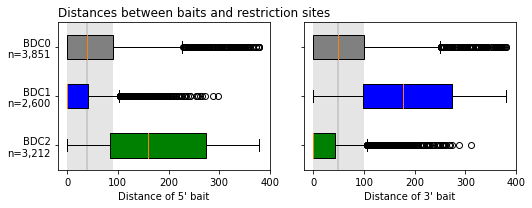

In [27]:
create_boxplot(
    BDC0_L=bdc0_l_dist_list,
    BDC0_R=bdc0_r_dist_list,
    BDC1_L=bdc1_l_dist_list,
    BDC1_R=bdc1_r_dist_list,
    BDC2_L=bdc2_l_dist_list,
    BDC2_R=bdc2_r_dist_list,
    SHOWFLIERS = True,
    TITLE='Distances between baits and restriction sites',
    XLABEL_L='Distance of 5\' bait',
    XLABEL_R='Distance of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distances_between_baits_and_restriction_sites.pdf')

On the left are the boxplots for the distances of the `5'` baits and on the right the boxplots for the distances of the `3'` baits. The top boxplots (gray) show the distributions of distances for baited digests of the class BDC0. The range between the first and third quantile is highlighted in lightgray. Below the boxplots for BDC0, the boxplots for BDC1 (blue) and BDC2 (green) are shown. The distributions of distances for the `5'` and `3'` baits differ only slightly for BDC0, while they differ clearly for BDC1 and BDC2. The boxplots for BDC1 and BDC2 are asymmetrical to each other.

The boxplots above show the distributions of `5'` and `3'` baits independently. In fact, however, we have a pair of distances for each digest. The following lines of code calculate the differences in distances for each pair.

In [28]:
# Get lists with differences for distances
bdc0_diff_dist_list = [x[0]-x[1] for x in zip(bdc0_l_dist_list, bdc0_r_dist_list)]
bdc1_diff_dist_list = [x[0]-x[1] for x in zip(bdc1_l_dist_list, bdc1_r_dist_list)]
bdc2_diff_dist_list = [x[0]-x[1] for x in zip(bdc2_l_dist_list, bdc2_r_dist_list)]

We use the same plot function as before, but this time, for each baited digest class, we pass the same list of differences for `5'` and `3'` baits. This results in two identical plots. This way we can reuse the plot function.

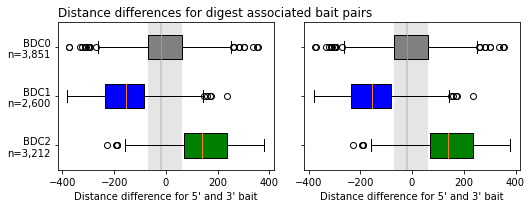

In [29]:
create_boxplot(
    BDC0_L=bdc0_diff_dist_list,
    BDC0_R=bdc0_diff_dist_list,
    BDC1_L=bdc1_diff_dist_list,
    BDC1_R=bdc1_diff_dist_list,
    BDC2_L=bdc2_diff_dist_list,
    BDC2_R=bdc2_diff_dist_list,
    SHOWFLIERS = True,
    TITLE='Distance differences for digest associated bait pairs',
    XLABEL_L='Distance difference for 5\' and 3\' bait',
    XLABEL_R='Distance difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_distance_differences_for_digest_associated_bait_pairs.pdf')

The differences of BDC0 are distributed relatively evenly (not perfectly) around zero. In contrast, a strong asymmetry can be seen for BDC1 and BDC2. To assess the deviations from zero for statistical significance, we use the non-parametric Wilcoxon signed rank test.

In [30]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_dist_list))
print(stats.wilcoxon(bdc1_diff_dist_list))
print(stats.wilcoxon(bdc2_diff_dist_list))

WilcoxonResult(statistic=3412873.0, pvalue=2.920852605531886e-05)
WilcoxonResult(statistic=95004.5, pvalue=0.0)
WilcoxonResult(statistic=216147.5, pvalue=0.0)


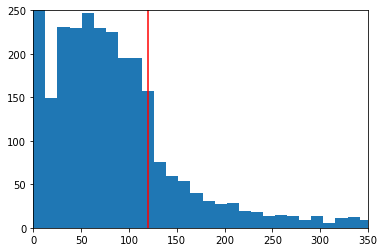

In [31]:
plt.hist(bdc0_l_dist_list,30)
plt.xlim(0, 350)
plt.ylim(0, 250)
plt.axvline(120, color='r')

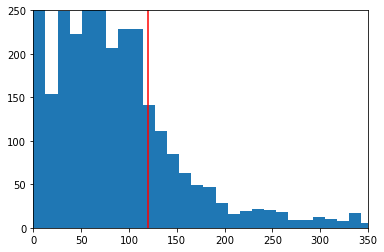

In [32]:
plt.hist(bdc0_r_dist_list,30)
plt.xlim(0, 350)
plt.ylim(0, 250)
plt.axvline(120, color='r')

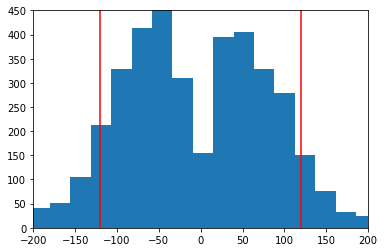

In [33]:
plt.hist(bdc0_diff_dist_list,30)
plt.xlim(-200, 200)
plt.ylim(0, 450)
plt.axvline(-120, color='r')
plt.axvline(120, color='r')

For BDC0, the deviation from zero is statistically significant. This could be due to differing coordinate systems (0-based or 1-based) or differing definition of the exact restriction sites. For BDC1 and BDC2, the P-value is so small that it is reported as zero.

We compare the distributions of differences for all pairs of BDC0, BDC1 and BDC2 using a Wilcoxon rank-sum test.

In [34]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_dist_list, bdc1_diff_dist_list))
print(stats.ranksums(bdc0_diff_dist_list, bdc2_diff_dist_list))
print(stats.ranksums(bdc1_diff_dist_list, bdc2_diff_dist_list))

RanksumsResult(statistic=47.578401244194254, pvalue=0.0)
RanksumsResult(statistic=-49.866564802272286, pvalue=0.0)
RanksumsResult(statistic=-61.11129034430268, pvalue=0.0)


The distributions are very different for all pairs and a P-value of zero is reported in all cases.

**Conclusion:** There is a strong correlation between the placment of baits and the assignment of the digests to the classes BDC0, BDC1 and BDC2. If the baits are not placed right next to the restriction site, the probability that the target sequence is part of a chimeric fragment is reduced.

## Further investigation of digest with two well placed baits

Poor placement of baits obviously has a significant impact on bait efficiency. In order to make more subtle influencing factors visible, we have removed all digests where the distances of the two baits to the digest ends are very different.

||BDC0|BDC1|BDC2|TOTAL|
|---|---|---|---|---|
|ALL|7,061|6,873|8,121|22,055|
|BOTH_SIDES|6,243|4,057|5,161|15,461|
|WELL_PLACED|3,159|1,176|1,821|6,156|

### GC content of baits

First, we create a dictionary from which the sequences of baits can be retrieved via their coordinates.

In [35]:
BAIT_SEQ_dict = dict()
OUT_PREFIX
MIFSUD_BAIT_FILE.sequence(fi=HG38_GENOME_FILE, fo=NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', tab=True)
with open(NOTEBOOK_RESULTS_DIR + '/bait_sequences.fa', 'rt') as fp:
    for line in fp:
        coords, seq = line.rstrip().split('\t')
        chrom = coords.split(':')[0]
        sta = coords.split(':')[1].split('-')[0]
        end = coords.split(':')[1].split('-')[1]
        BAIT_SEQ_dict[chrom + '\t' + sta + '\t' + end] = seq

I addition, we define a function that that returns the GC and repeat content of a given DNA sequence.

In [36]:
def get_gc_and_repeat_content(sequence):
    
    # Determine GC content
    GC_count = sequence.count('g')
    GC_count += sequence.count('G')
    GC_count += sequence.count('c')
    GC_count += sequence.count('C')
    seq_len = len(sequence)
    gc_content = GC_count/seq_len
    
    # Determine repeat content
    sequence = sub("[a-z]", 'R', sequence)
    R_count = sequence.count('R')
    repeat_content = R_count/seq_len
    
    return gc_content, repeat_content

Here is a fuction call to illustrate how it works.

In [37]:
get_gc_and_repeat_content('NtacgCGCGC')

(0.7, 0.4)

Lowercase letters represent repeats. The GC content is determined without regard to repeats. Positions with `N` are not taken into account when determining the repeat content.

A digest dictionaty with well placed baits is passed to the following function. For each digest, the GC and repeat contents of the two baits are determined and appended to lists that are returned at the end.

In [38]:
def get_gc_and_repeat_content_of_baits(well_placed_baits_dict, bd_classes=[0,1,2]):
    l_gc_list = []
    r_gc_list = []
    l_repeat_list = []
    r_repeat_list = []
    for d_key in well_placed_baits_dict.keys():
    
        # Filter for digests with specified baited digest classes
        if well_placed_baits_dict[d_key]['BDC'] not in bd_classes:
            continue

        # Get GC and repeat content of 5' bait
        seq = BAIT_SEQ_dict[well_placed_baits_dict[d_key]['L_COORDS'][0]]
        gc_content, repeat_content = get_gc_and_repeat_content(seq)
        l_gc_list.append(gc_content)
        l_repeat_list.append(repeat_content)

        # Get GC and repeat content of 3' bait
        seq = BAIT_SEQ_dict[well_placed_baits_dict[d_key]['R_COORDS'][0]]
        gc_content, repeat_content = get_gc_and_repeat_content(seq)
        r_gc_list.append(gc_content)
        r_repeat_list.append(repeat_content)
      
    print('BDC' + str(bd_classes))
    print('GC contents 5\' baits: ' + '{:,}'.format(len(l_gc_list)))
    print('GC contents 3\' baits: ' + '{:,}'.format(len(r_gc_list)))
    print('Repeat contents 5\' baits: ' + '{:,}'.format(len(l_repeat_list)))
    print('Repeat contents 3\' baits: ' + '{:,}'.format(len(r_repeat_list)))
    print()
        
    return l_gc_list, r_gc_list, l_repeat_list, r_repeat_list

We use this funtion to generate separate lists with GC and repeat contents for the baited digests of the different classes.

In [39]:
bdc0_l_gc_list, bdc0_r_gc_list, bdc0_l_repeat_list, bdc0_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc0_well_placed_dict,
    bd_classes=[0])

bdc1_l_gc_list, bdc1_r_gc_list, bdc1_l_repeat_list, bdc1_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc1_well_placed_dict,
    bd_classes=[1])

bdc2_l_gc_list, bdc2_r_gc_list, bdc2_l_repeat_list, bdc2_r_repeat_list = get_gc_and_repeat_content_of_baits(
    bdc2_well_placed_dict,
    bd_classes=[2])

BDC[0]
GC contents 5' baits: 3,616
GC contents 3' baits: 3,616
Repeat contents 5' baits: 3,616
Repeat contents 3' baits: 3,616

BDC[1]
GC contents 5' baits: 711
GC contents 3' baits: 711
Repeat contents 5' baits: 711
Repeat contents 3' baits: 711

BDC[2]
GC contents 5' baits: 1,429
GC contents 3' baits: 1,429
Repeat contents 5' baits: 1,429
Repeat contents 3' baits: 1,429



Then we use our boxplot function to compare the distributions of GC contents.

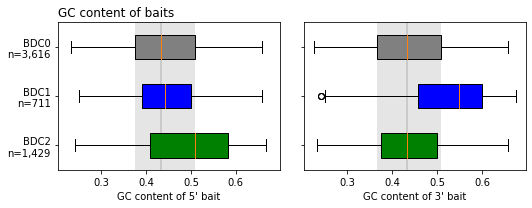

In [40]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list,
    BDC0_R=bdc0_r_gc_list,
    BDC1_L=bdc1_l_gc_list,
    BDC1_R=bdc1_r_gc_list,
    BDC2_L=bdc2_l_gc_list,
    BDC2_R=bdc2_r_gc_list,
    SHOWFLIERS = True,
    TITLE='GC content of baits',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits.pdf')

For BDC0, the GC contents of the `5'` and `3'` baits show a similar distribution. In contrast, these distributions are very different for BDC1 and BDC2. For BCD1, the distribution for the `3'` baits is shifted towards larger GC contents. For BDC2, it is the other way arround. Here the distribution for the `5'` is shifted towards larger GC contents. This could indicate that too high GC content has a negative impact on the efficiency of baits.

We again determine the differences for the bait pairs of all digests, as we did for the distances from baits to digest ends, but this time for the GC contents.

In [41]:
# Get lists with differences for GC content
bdc0_diff_gc_list = [x[0]-x[1] for x in zip(bdc0_l_gc_list, bdc0_r_gc_list)]
bdc1_diff_gc_list = [x[0]-x[1] for x in zip(bdc1_l_gc_list, bdc1_r_gc_list)]
bdc2_diff_gc_list = [x[0]-x[1] for x in zip(bdc2_l_gc_list, bdc2_r_gc_list)]

Then we use our boxplot function to visualize the distributions of differences. Remember that in this case the boxplots on the left and right are identical.

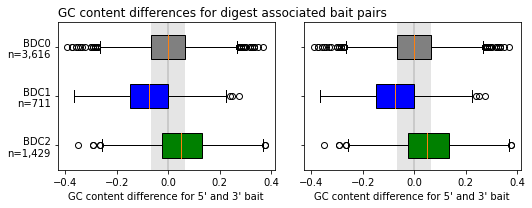

In [42]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list,
    BDC0_R=bdc0_diff_gc_list,
    BDC1_L=bdc1_diff_gc_list,
    BDC1_R=bdc1_diff_gc_list,
    BDC2_L=bdc2_diff_gc_list,
    BDC2_R=bdc2_diff_gc_list,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_digest_associated_bait_pairs.pdf')

For BDC0, the differences are evenly distributed around zero. For BDC1, the distribution is shifted towards negative differences. This means that there are many bait pairs for which the GC content of the `3'` bait is higher than that of the `5'` bait. For BDC2 it is the exact opposite. Here, there are many pairs where the GC content of the `5'` bait is higher.

We use the Wilcoxon signed rank test to test the deviations from zero for statistical significance.

In [43]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list))
print(stats.wilcoxon(bdc1_diff_gc_list))
print(stats.wilcoxon(bdc2_diff_gc_list))

WilcoxonResult(statistic=3064728.0, pvalue=0.9016349588001095)
WilcoxonResult(statistic=42197.5, pvalue=8.483056473011877e-50)
WilcoxonResult(statistic=237248.5, pvalue=2.059890890640147e-62)


For BDC0, the differences do not deviate significantly from zero. For BDC1 and BDC2, the deviations are significant.

We use the Wilcoxon rank sum test to test the null hypothesis that the differences for BDC0, BDC1 and BDC2 come from the same distribution.

In [44]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_gc_list, bdc1_diff_gc_list))
print(stats.ranksums(bdc0_diff_gc_list, bdc2_diff_gc_list))
print(stats.ranksums(bdc1_diff_gc_list, bdc2_diff_gc_list))

RanksumsResult(statistic=16.122901895498206, pvalue=1.7614017232301522e-58)
RanksumsResult(statistic=-15.426696792595951, pvalue=1.0827166679103387e-53)
RanksumsResult(statistic=-21.977587056177065, pvalue=4.718846120919771e-107)


The distributions of differences for BDC0, BDC1 and BDC2 differ significantly from each other.

### Repeat content of baits

For the repeat content of baits, we perform the same analysis as for the GC content of baits. As before, we use the digest with two well-placed baits for our analysis. First, we create the boxplots showing the distributions of repeat contents separately for `5'` and `3'` baits.

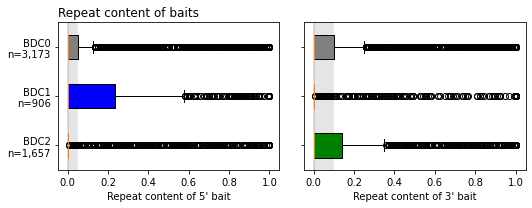

In [83]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list,
    BDC0_R=bdc0_r_repeat_list,
    BDC1_L=bdc1_l_repeat_list,
    BDC1_R=bdc1_r_repeat_list,
    BDC2_L=bdc2_l_repeat_list,
    BDC2_R=bdc2_r_repeat_list,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits.pdf')

For BDC0, the repeat content distributions of `5'` and `3'` baits are similar. For BDC1 and BDC2, these distributions are very different. For BDC1, most of the repeat contents of the `3'` baits seem to be zero and, for BDC2, it is the exact opposite.

We again determine the differences of repeat contents for all bait pairs and create boxplots.

In [84]:
## Get lists with differences for repeat content
bdc0_diff_repeat_list = [x[0]-x[1] for x in zip(bdc0_l_repeat_list, bdc0_r_repeat_list)]
bdc1_diff_repeat_list = [x[0]-x[1] for x in zip(bdc1_l_repeat_list, bdc1_r_repeat_list)]
bdc2_diff_repeat_list = [x[0]-x[1] for x in zip(bdc2_l_repeat_list, bdc2_r_repeat_list)]

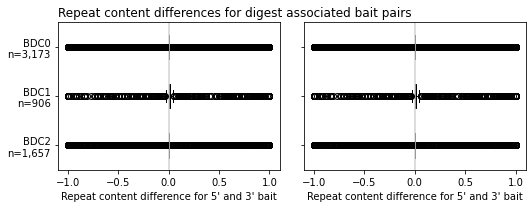

In [85]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list,
    BDC0_R=bdc0_diff_repeat_list,
    BDC1_L=bdc1_diff_repeat_list,
    BDC1_R=bdc1_diff_repeat_list,
    BDC2_L=bdc2_diff_repeat_list,
    BDC2_R=bdc2_diff_repeat_list,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs.pdf')

Then we perform the statistical tests.

In [86]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list))
print(stats.wilcoxon(bdc1_diff_repeat_list))
print(stats.wilcoxon(bdc2_diff_repeat_list))

WilcoxonResult(statistic=499462.5, pvalue=0.6781786508981713)
WilcoxonResult(statistic=30877.5, pvalue=1.8946207760505995e-05)
WilcoxonResult(statistic=109533.0, pvalue=0.00011374538320735483)


Judging by the test, the differences for BDC1 and BDC2 deviate significantly from zero, but not for BDC0.

In [87]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list, bdc1_diff_repeat_list))
print(stats.ranksums(bdc0_diff_repeat_list, bdc2_diff_repeat_list))
print(stats.ranksums(bdc1_diff_repeat_list, bdc2_diff_repeat_list))

RanksumsResult(statistic=-3.089730140293682, pvalue=0.0020033843005366953)
RanksumsResult(statistic=2.117415593377883, pvalue=0.03422459193992687)
RanksumsResult(statistic=4.404262153942583, pvalue=1.061445239790701e-05)


BDC1 and BDC2 differ only slightly from BDC0. But among themselves, BDC1 and BDC2 differ significantly.

#### Remove all digests for which the repeat content of both baits is zero

The boxplot for the repeat content of BDC1 `3'` baits and the BDC2 `5'` baits look strange. This is because in these cases the repeat content is zero for more than 75% of the digests.

In [88]:
print('5\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_l_repeat_list.count(0.00)/len(bdc0_l_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_l_repeat_list.count(0.00)/len(bdc1_l_repeat_list)))
print('BDC2: ' + '{:.2f}'.format(bdc2_l_repeat_list.count(0.00)/len(bdc2_l_repeat_list)) + ' !')
print()
print('3\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_r_repeat_list.count(0.00)/len(bdc0_r_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_r_repeat_list.count(0.00)/len(bdc1_r_repeat_list)) + ' !')
print('BDC2: ' + '{:.2f}'.format(bdc2_r_repeat_list.count(0.00)/len(bdc2_r_repeat_list)))

5' baits
BDC0: 0.74
BDC1: 0.70
BDC2: 0.76 !

3' baits
BDC0: 0.72
BDC1: 0.77 !
BDC2: 0.72


More than half of the differences are also equal zero.

In [89]:
print('Differences between 5\' and 3\' baits')
print('BDC0: ' + '{:.2f}'.format(bdc0_diff_repeat_list.count(0.00)/len(bdc0_diff_repeat_list)))
print('BDC1: ' + '{:.2f}'.format(bdc1_diff_repeat_list.count(0.00)/len(bdc1_diff_repeat_list)))
print('BDC2: ' + '{:.2f}'.format(bdc2_diff_repeat_list.count(0.00)/len(bdc2_diff_repeat_list)))

Differences between 5' and 3' baits
BDC0: 0.55
BDC1: 0.55
BDC2: 0.56


This means that more than the half of the digests have two baits with no repeats. These digests are not informative for this analysis (true?) and they interfere with the display in the boxplots. Therefore, we removed all digests for which the repeat content of both digests is zero.

In [90]:
bdc0_l_repeat_list_f1, bdc0_r_repeat_list_f1, bdc0_l_gc_list_f1, bdc0_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc0_l_repeat_list, bdc0_r_repeat_list, bdc0_l_gc_list, bdc0_r_gc_list))))

bdc1_l_repeat_list_f1, bdc1_r_repeat_list_f1, bdc1_l_gc_list_f1, bdc1_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc1_l_repeat_list, bdc1_r_repeat_list, bdc1_l_gc_list, bdc1_r_gc_list))))

bdc2_l_repeat_list_f1, bdc2_r_repeat_list_f1, bdc2_l_gc_list_f1, bdc2_r_gc_list_f1 = \
    zip(*list(filter(lambda x: 0<x[0] or 0<x[1], zip(bdc2_l_repeat_list, bdc2_r_repeat_list, bdc2_l_gc_list, bdc2_r_gc_list))))

Then we plotted the repeat content of the remaining pairs in a boxplot.

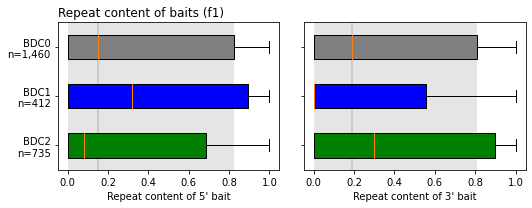

In [91]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list_f1,
    BDC0_R=bdc0_r_repeat_list_f1,
    BDC1_L=bdc1_l_repeat_list_f1,
    BDC1_R=bdc1_r_repeat_list_f1,
    BDC2_L=bdc2_l_repeat_list_f1,
    BDC2_R=bdc2_r_repeat_list_f1,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits (f1)',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits_f1.pdf')

For BDC0, the distributions of the repeat contents of `5'` and `3'` baits are almost the same. For BCD1, the `3'` baits have lower repeat content and, for BDC2, the `5'` baits have lower repeat content. This contradicts the explanatory model with the unequal efficiency of baits. Normally, baits with higher repeat content are assumed to less efficient because they bind not only to the target region, but to other regions as well.

We again determine the differences of repeat contents for all bait pairs, create boxplots and perform the statistical tests.

In [92]:
# Get lists with differences for repeat content (filtered)
bdc0_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc0_l_repeat_list_f1, bdc0_r_repeat_list_f1)]
bdc1_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc1_l_repeat_list_f1, bdc1_r_repeat_list_f1)]
bdc2_diff_repeat_list_f1 = [x[0]-x[1] for x in zip(bdc2_l_repeat_list_f1, bdc2_r_repeat_list_f1)]

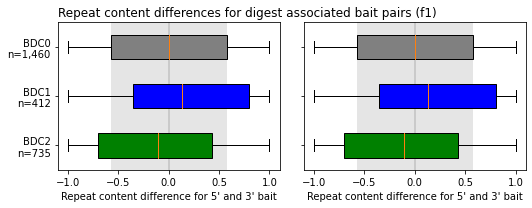

In [93]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list_f1,
    BDC0_R=bdc0_diff_repeat_list_f1,
    BDC1_L=bdc1_diff_repeat_list_f1,
    BDC1_R=bdc1_diff_repeat_list_f1,
    BDC2_L=bdc2_diff_repeat_list_f1,
    BDC2_R=bdc2_diff_repeat_list_f1,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs (f1)',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs_f1.pdf')

For BDC0, the differences are evenly distributed around zero. For BDC1, the repeat content of the `3'` bait is often less than that of the `5'` bait and, for BDC2, the opposite is true.

In [94]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list_f1))
print(stats.wilcoxon(bdc1_diff_repeat_list_f1))
print(stats.wilcoxon(bdc2_diff_repeat_list_f1))

WilcoxonResult(statistic=499462.5, pvalue=0.6781786508981713)
WilcoxonResult(statistic=30877.5, pvalue=1.8946207760505995e-05)
WilcoxonResult(statistic=109533.0, pvalue=0.00011374538320735483)


In [96]:
# Perform Wilcoxon rank-sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list_f1, bdc1_diff_repeat_list_f1))
print(stats.ranksums(bdc0_diff_repeat_list_f1, bdc2_diff_repeat_list_f1))
print(stats.ranksums(bdc1_diff_repeat_list_f1, bdc2_diff_repeat_list_f1))

RanksumsResult(statistic=-3.9245400292457204, pvalue=8.689561008093156e-05)
RanksumsResult(statistic=2.8795868730432046, pvalue=0.003981965768250202)
RanksumsResult(statistic=5.740977976839431, pvalue=9.413133365913694e-09)


The results of the statistical tests are not very different from those obtained before we removed all digests that have two baits without repeats.

Repeat GC content analysis for non-zero repeat digests.

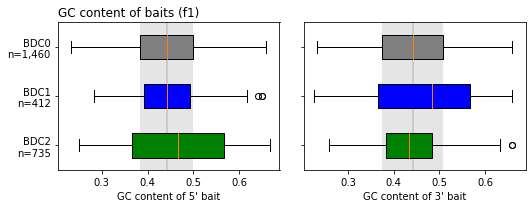

In [97]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list_f1,
    BDC0_R=bdc0_r_gc_list_f1,
    BDC1_L=bdc1_l_gc_list_f1,
    BDC1_R=bdc1_r_gc_list_f1,
    BDC2_L=bdc2_l_gc_list_f1,
    BDC2_R=bdc2_r_gc_list_f1,
    SHOWFLIERS = True,
    TITLE='GC content of baits (f1)',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits_f1.pdf')

In [98]:
# Get lists with differences for gc content (filtered)
bdc0_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc0_l_gc_list_f1, bdc0_r_gc_list_f1)]
bdc1_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc1_l_gc_list_f1, bdc1_r_gc_list_f1)]
bdc2_diff_gc_list_f1 = [x[0]-x[1] for x in zip(bdc2_l_gc_list_f1, bdc2_r_gc_list_f1)]

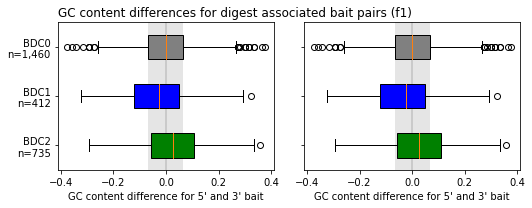

In [99]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list_f1,
    BDC0_R=bdc0_diff_gc_list_f1,
    BDC1_L=bdc1_diff_gc_list_f1,
    BDC1_R=bdc1_diff_gc_list_f1,
    BDC2_L=bdc2_diff_gc_list_f1,
    BDC2_R=bdc2_diff_gc_list_f1,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs (f1)',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_differences_for_digest_associated_bait_pairs_f1.pdf')

In [100]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list_f1))
print(stats.wilcoxon(bdc1_diff_gc_list_f1))
print(stats.wilcoxon(bdc2_diff_gc_list_f1))

WilcoxonResult(statistic=488250.5, pvalue=0.6129979703441251)
WilcoxonResult(statistic=29122.5, pvalue=2.9253637386526054e-06)
WilcoxonResult(statistic=94560.5, pvalue=1.0459011543164346e-09)


### Dependency between GC and repeat content

High GC content could be negatively correlated with repeat content. To test this hypothesis, we determined the GC and repeat content of all baits.

In [101]:
# Get GC and repeat content of all baits
gc_list = []
repeat_list = []
for bait_seq in BAIT_SEQ_dict.values():
    gc_content, repeat_content = get_gc_and_repeat_content(bait_seq)
    gc_list.append(gc_content)
    repeat_list.append(repeat_content)

Then we divide all baits into those with and without repeats, and within these groups, we further divide them into low and high GC baits. To distinguish between low and high GC baits, we use the median GC content of all baits as a threshold. Then we determine the numbers of baits in the four groups and perform a Fisher's exact test.

In [102]:
GC_LOW_HIGH_THRESH = median(gc_list)
print('GC_LOW_HIGH_THRESH: ' + '{:.2f}'.format(GC_LOW_HIGH_THRESH))
print()
x, y = \
    zip(*list(filter(lambda x: x[0]==0 and x[1]<=GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
ZERO_REPEAT_GC_LOW = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]==0 and x[1]>GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
ZERO_REPEAT_GC_HIGH = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]>0 and x[1]<=GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
NON_ZERO_REPEAT_GC_LOW = len(y)
x, y = \
    zip(*list(filter(lambda x: x[0]>0 and x[1]>GC_LOW_HIGH_THRESH, zip(repeat_list, gc_list))))
NON_ZERO_REPEAT_GC_HIGH = len(y)

ZERO_REPEAT_TOTAL = ZERO_REPEAT_GC_LOW + ZERO_REPEAT_GC_HIGH
NON_ZERO_REPEAT_TOTAL = NON_ZERO_REPEAT_GC_LOW + NON_ZERO_REPEAT_GC_HIGH
GC_LOW_TOTAL = ZERO_REPEAT_GC_LOW + NON_ZERO_REPEAT_GC_LOW
GC_HIGH_TOTAL = ZERO_REPEAT_GC_HIGH + NON_ZERO_REPEAT_GC_HIGH

d = {'Low GC': ['{:,}'.format(ZERO_REPEAT_GC_LOW),
                '{:,}'.format(NON_ZERO_REPEAT_GC_LOW),
                '{:,}'.format(GC_LOW_TOTAL)],
     'High GC': ['{:,}'.format(ZERO_REPEAT_GC_HIGH),
                 '{:,}'.format(NON_ZERO_REPEAT_GC_HIGH),
                 '{:,}'.format(GC_HIGH_TOTAL)],
     'Total': ['{:,}'.format(ZERO_REPEAT_TOTAL),
               '{:,}'.format(NON_ZERO_REPEAT_TOTAL),
               '{:,}'.format(ZERO_REPEAT_TOTAL + NON_ZERO_REPEAT_TOTAL)]}
df = pd.DataFrame(data=d)
df.index = ['Zero repeat', 'Non-zero repeat', 'Total']
print(df)

# Fisher's exact test
contingency_table = [
    [ZERO_REPEAT_GC_LOW, ZERO_REPEAT_GC_HIGH],
    [NON_ZERO_REPEAT_GC_LOW, NON_ZERO_REPEAT_GC_HIGH]]

odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')
print('Prior odds ratio: ' + str(odds_ratio))
print('P-value: ' + str(p_value))

GC_LOW_HIGH_THRESH: 0.43

                 Low GC High GC   Total
Zero repeat      11,607  12,380  23,987
Non-zero repeat   7,724   5,891  13,615
Total            19,331  18,271  37,602
Prior odds ratio: 0.7150659484860984
P-value: 1.251786508767154e-54


Among the baits with a high GC content, the proportion of baits without repeats is significantly higher.

### Remove digests in which one of the baits has very high GC content

We have removed all digests for which at least one of the baits has a GC content of more than that of 75% of all baits, which is `0.52`.

In [103]:
GC_HIGH_THRESH = quantile(gc_list, 0.75)
print(GC_HIGH_THRESH)

0.5166666666666667


In [104]:
bdc0_l_gc_list_f2, bdc0_r_gc_list_f2, bdc0_l_repeat_list_f2, bdc0_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc0_l_gc_list, bdc0_r_gc_list, bdc0_l_repeat_list, bdc0_r_repeat_list))))

bdc1_l_gc_list_f2, bdc1_r_gc_list_f2, bdc1_l_repeat_list_f2, bdc1_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc1_l_gc_list, bdc1_r_gc_list, bdc1_l_repeat_list, bdc1_r_repeat_list))))

bdc2_l_gc_list_f2, bdc2_r_gc_list_f2, bdc2_l_repeat_list_f2, bdc2_r_repeat_list_f2 = \
    zip(*list(filter(lambda x: x[0]<GC_HIGH_THRESH and x[1]<GC_HIGH_THRESH and (0<x[2] or 0<x[3]), zip(bdc2_l_gc_list, bdc2_r_gc_list, bdc2_l_repeat_list, bdc2_r_repeat_list))))

First, we run the analysis for GC content again using the filtered data.

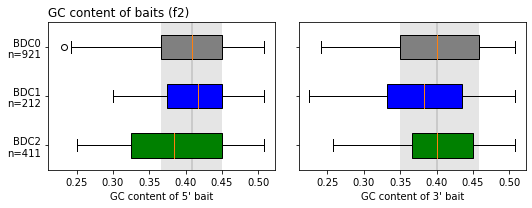

In [105]:
create_boxplot(
    BDC0_L=bdc0_l_gc_list_f2,
    BDC0_R=bdc0_r_gc_list_f2,
    BDC1_L=bdc1_l_gc_list_f2,
    BDC1_R=bdc1_r_gc_list_f2,
    BDC2_L=bdc2_l_gc_list_f2,
    BDC2_R=bdc2_r_gc_list_f2,
    SHOWFLIERS = True,
    TITLE='GC content of baits (f2)',
    XLABEL_L='GC content of 5\' bait',
    XLABEL_R='GC content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_of_baits_f2.pdf')

In [106]:
# Get lists with differences for GC content (x)
bdc0_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc0_l_gc_list_f2, bdc0_r_gc_list_f2)]
bdc1_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc1_l_gc_list_f2, bdc1_r_gc_list_f2)]
bdc2_diff_gc_list_f2 = [x[0]-x[1] for x in zip(bdc2_l_gc_list_f2, bdc2_r_gc_list_f2)]

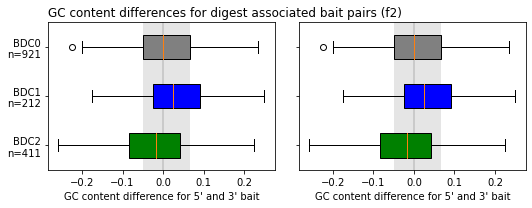

In [107]:
create_boxplot(
    BDC0_L=bdc0_diff_gc_list_f2,
    BDC0_R=bdc0_diff_gc_list_f2,
    BDC1_L=bdc1_diff_gc_list_f2,
    BDC1_R=bdc1_diff_gc_list_f2,
    BDC2_L=bdc2_diff_gc_list_f2,
    BDC2_R=bdc2_diff_gc_list_f2,
    SHOWFLIERS = True,
    TITLE='GC content differences for digest associated bait pairs (f2)',
    XLABEL_L='GC content difference for 5\' and 3\' bait',
    XLABEL_R='GC content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_gc_content_differences_for_digest_associated_bait_pairs_f2.pdf')

In [108]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_gc_list_f2))
print(stats.wilcoxon(bdc1_diff_gc_list_f2))
print(stats.wilcoxon(bdc2_diff_gc_list_f2))

WilcoxonResult(statistic=177958.0, pvalue=0.04049116147263929)
WilcoxonResult(statistic=6161.5, pvalue=2.074283384982487e-06)
WilcoxonResult(statistic=29175.5, pvalue=1.2193726727249178e-05)


In [109]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_gc_list_f2, bdc1_diff_gc_list_f2))
print(stats.ranksums(bdc0_diff_gc_list_f2, bdc2_diff_gc_list_f2))
print(stats.ranksums(bdc1_diff_gc_list_f2, bdc2_diff_gc_list_f2))

RanksumsResult(statistic=-3.7311145883847567, pvalue=0.00019063448356170225)
RanksumsResult(statistic=4.809560423629664, pvalue=1.5126256749879054e-06)
RanksumsResult(statistic=6.3817113921927, pvalue=1.7511976922042148e-10)


**No significant deviations from zero!**

Run the repeat content analysis again using the filtered data.

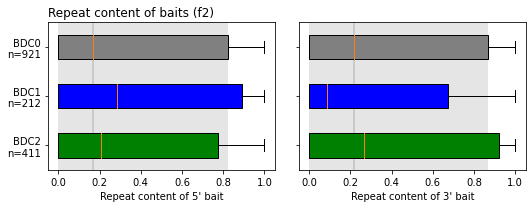

In [110]:
create_boxplot(
    BDC0_L=bdc0_l_repeat_list_f2,
    BDC0_R=bdc0_r_repeat_list_f2,
    BDC1_L=bdc1_l_repeat_list_f2,
    BDC1_R=bdc1_r_repeat_list_f2,
    BDC2_L=bdc2_l_repeat_list_f2,
    BDC2_R=bdc2_r_repeat_list_f2,
    SHOWFLIERS = True,
    TITLE='Repeat content of baits (f2)',
    XLABEL_L='Repeat content of 5\' bait',
    XLABEL_R='Repeat content of 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_of_baits_f2.pdf')

In [111]:
# Get lists with differences for repeat content (x)
bdc0_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc0_l_repeat_list_f2, bdc0_r_repeat_list_f2)]
bdc1_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc1_l_repeat_list_f2, bdc1_r_repeat_list_f2)]
bdc2_diff_repeat_list_f2 = [x[0]-x[1] for x in zip(bdc2_l_repeat_list_f2, bdc2_r_repeat_list_f2)]

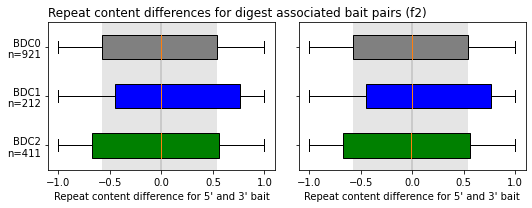

In [112]:
create_boxplot(
    BDC0_L=bdc0_diff_repeat_list_f2,
    BDC0_R=bdc0_diff_repeat_list_f2,
    BDC1_L=bdc1_diff_repeat_list_f2,
    BDC1_R=bdc1_diff_repeat_list_f2,
    BDC2_L=bdc2_diff_repeat_list_f2,
    BDC2_R=bdc2_diff_repeat_list_f2,
    SHOWFLIERS = True,
    TITLE='Repeat content differences for digest associated bait pairs (f2)',
    XLABEL_L='Repeat content difference for 5\' and 3\' bait',
    XLABEL_R='Repeat content difference for 5\' and 3\' bait',
    OUTPUT_PDF=NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX  + '_repeat_content_differences_for_digest_associated_bait_pairs_f2.pdf')

In [113]:
# Perform Wilcoxon signed-rank test
print(stats.wilcoxon(bdc0_diff_repeat_list_f2))
print(stats.wilcoxon(bdc1_diff_repeat_list_f2))
print(stats.wilcoxon(bdc2_diff_repeat_list_f2))

WilcoxonResult(statistic=193426.0, pvalue=0.4923126540621652)
WilcoxonResult(statistic=9087.5, pvalue=0.0834736435732121)
WilcoxonResult(statistic=37912.0, pvalue=0.20172545323775504)


In [114]:
# Perform Wilcoxon rank_sum test on differences
print(stats.ranksums(bdc0_diff_repeat_list_f2, bdc1_diff_repeat_list_f2))
print(stats.ranksums(bdc0_diff_repeat_list_f2, bdc2_diff_repeat_list_f2))
print(stats.ranksums(bdc1_diff_repeat_list_f2, bdc2_diff_repeat_list_f2))

RanksumsResult(statistic=-1.7776746113998878, pvalue=0.07545731180683521)
RanksumsResult(statistic=0.6279608832070539, pvalue=0.5300295653042706)
RanksumsResult(statistic=2.1136130413335508, pvalue=0.03454833107040542)
